In [39]:
import pprint as pp

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import keras
from keras import layers
from keras.losses import BinaryCrossentropy


In [3]:
# Load the Titanic dataset.
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.info()

titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.1+ KB


In [14]:

## TODO make this a class or at least a function
input_layers, preprocessed_inputs  = [], []
for name, col in titanic_features.items():

  print("processing %s ..." % name)

  cur_dtype = tf.string if col.dtype == object else tf.float32

  cur_input = tf.keras.Input(shape=(1,), name=name, dtype=cur_dtype)
  input_layers.append(cur_input)  

  if cur_dtype == tf.string:
    lookup = layers.StringLookup(vocabulary=np.unique(col))    
    norm = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
    normalized_input = norm(lookup(cur_input))
    preprocessed_inputs.append(normalized_input)

  else:
    norm = layers.Normalization(axis=None)
    norm.adapt(col)
    normalized_input = norm(cur_input)
    preprocessed_inputs.append( normalized_input )


preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
titanic_preprocessing = tf.keras.Model(input_layers, preprocessed_inputs_cat)

#tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR")


processing sex ...
processing age ...
processing n_siblings_spouses ...
processing parch ...
processing fare ...
processing class ...
processing deck ...
processing embark_town ...
processing alone ...


In [73]:

body = tf.keras.Sequential([
  layers.Dropout(0.10),
  layers.Dense(32),
  layers.Dense(1)
])

preprocessed_inputs = titanic_preprocessing(input_layers)
result = body(preprocessed_inputs)
titanic_model = tf.keras.Model(input_layers, result)
titanic_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

titanic_features_dict = {
  name: np.array(value) for name, value in titanic_features.items()
}

hist = titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=50) #, batch_size=10)


Epoch 1/50
20/20 [==============================] - 1s 4ms/step - loss: 8.5960 - accuracy: 0.3317
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 8.0114 - accuracy: 0.3748
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 6.2028 - accuracy: 0.4051
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 4.3978 - accuracy: 0.4514
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 3.8881 - accuracy: 0.4976
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 4.1112 - accuracy: 0.5040
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 4.0231 - accuracy: 0.5231
Epoch 8/50
20/20 [==============================] - 0s 4ms/step - loss: 3.8442 - accuracy: 0.5247
Epoch 9/50
20/20 [==============================] - 0s 4ms/step - loss: 3.5640 - accuracy: 0.5710
Epoch 10/50
20/20 [==============================] - 0s 4ms/step - loss: 3.0053 - accuracy: 0.6507
Epoch 11/50
20/20 [

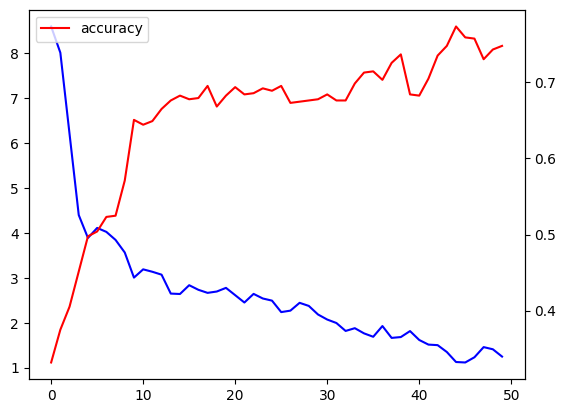

In [78]:

fig, ax1 = plt.subplots()
ax1.plot(hist.epoch, hist.history['loss'], label='loss', color="blue")
ax2 = ax1.twinx()
ax2.plot(hist.epoch, hist.history['accuracy'], label='accuracy', color="red")

plt.show()

